In [1]:
# initial notebook setup
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd /home/naodell/work/hgcal/analysis

/home/naodell/work/hgcal/analysis


In [2]:
import os
import pickle
from glob import glob

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import utils.geometry_tools as gt
import utils.plot_tools as pt

#from scipy.optimize import lsq_linear
#from sklearn.linear_model import LinearRegression

matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor':'white', 'figure.figsize':(8, 8)})


In [3]:
# get the data
input_file = open('local_data/tc_data/output_0.pkl', 'rb')
data_dict = pickle.load(input_file)
df_tc = data_dict['tc']
df_gen = data_dict['gen']

# get the data and apply some cuts
#cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
cuts = 'tc_zside == -1 and tc_subdet == 1 and tc_energy > 0.01'
df_cut = df_tc.query(cuts)
events = df_cut.index.get_level_values(0).unique()
event_ix = events[10]
event_tc = df_cut

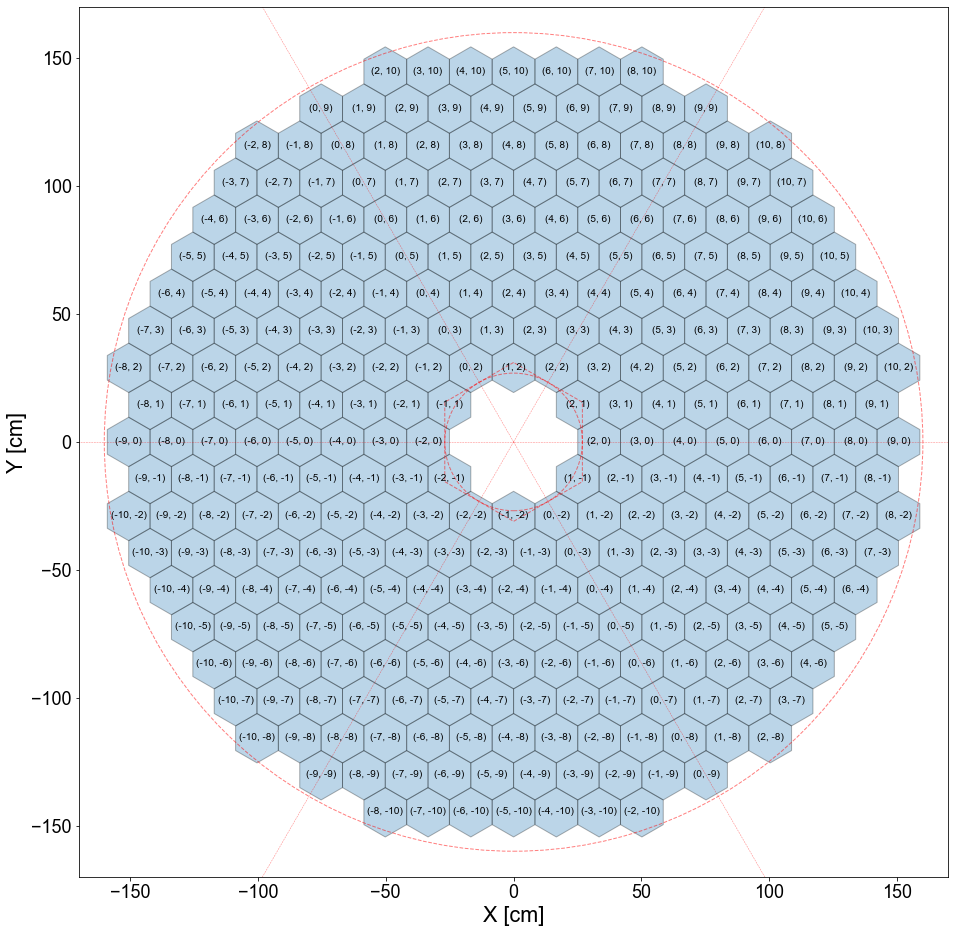

In [4]:
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

pt.draw_hgcal_layer(ax)

plt.savefig('plots/wafer_uv_mapping.pdf')
plt.show()

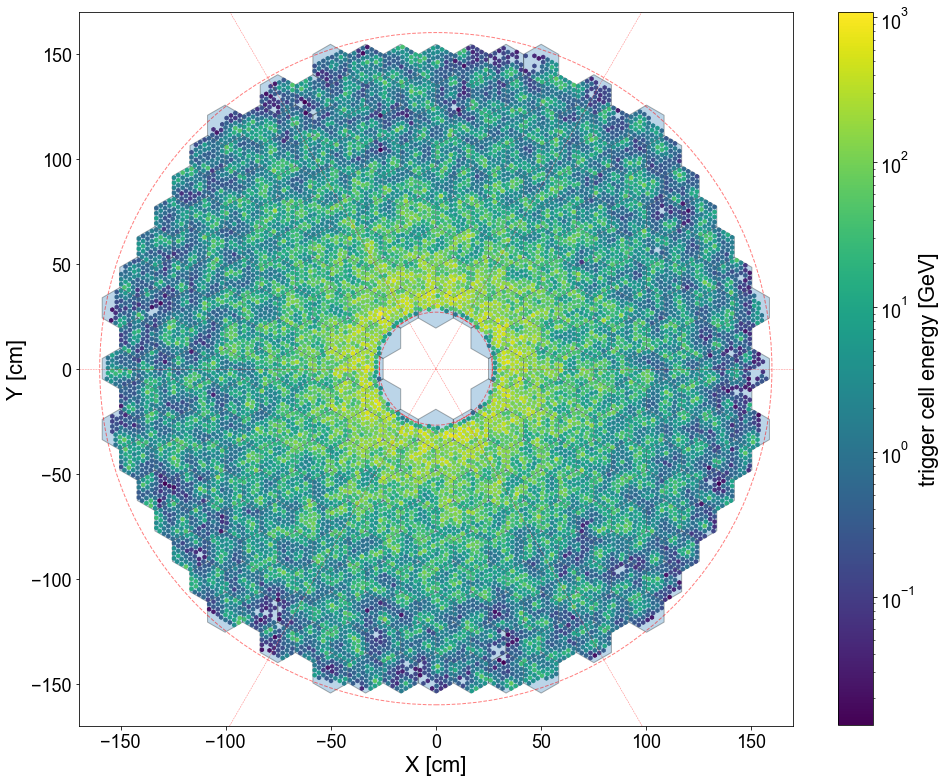

In [42]:
# Draw some events overlaid

# get the data and apply some cuts
#event_tc = df_cut.loc[event_ix]
#event_gen = df_gen.loc[event_ix]

group_wafer = event_tc.groupby(['tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

pt.draw_hgcal_layer(ax, include_index=False)
              
tc_sums = event_tc.query('tc_layer == 9').groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
scat = ax.scatter(x, y,
                  marker=(6, 0, 0), 
                  s=15, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm() 
                 )

cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
cbar.set_label('trigger cell energy [GeV]')

plt.savefig('plots/wafer_occupancy_test.png')
plt.show()

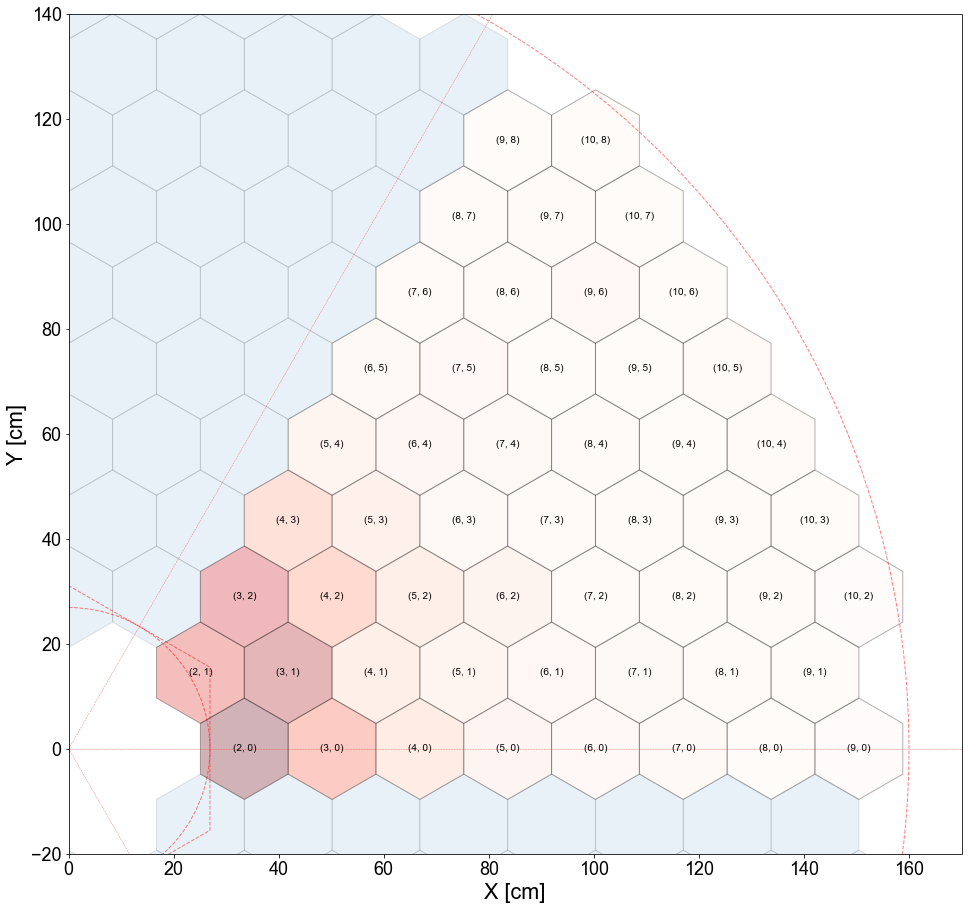

In [12]:
# Draw some events overlaid in the first wedge

# make some plots
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

wedge_condition = 'tc_waferu >= 2 and tc_waferu > tc_waferv and tc_waferv >= 0'
wafer_sums = event_tc.query(wedge_condition).groupby(['tc_waferu', 'tc_waferv']).sum()
pt.draw_hgcal_layer(ax, wafer_data=wafer_sums['tc_energy'], single_wedge=True, include_index=True)
    
#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
tc_sums = event_tc.query(wedge_condition).groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 20. #/ (1 + np.exp(-tc_energy)/10)
#scat = ax.scatter(x, y,
#                  marker='o', #(6, 0, 0), 
#                  s=marker_size, 
#                  c=tc_energy,
#                  zorder=2,
#                  norm=matplotlib.colors.LogNorm()
#                 )
#
#cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
#cbar.set_label('trigger cell energy [a.u.]')

plt.savefig('plots/first_wedge_indexing.png')
plt.show()

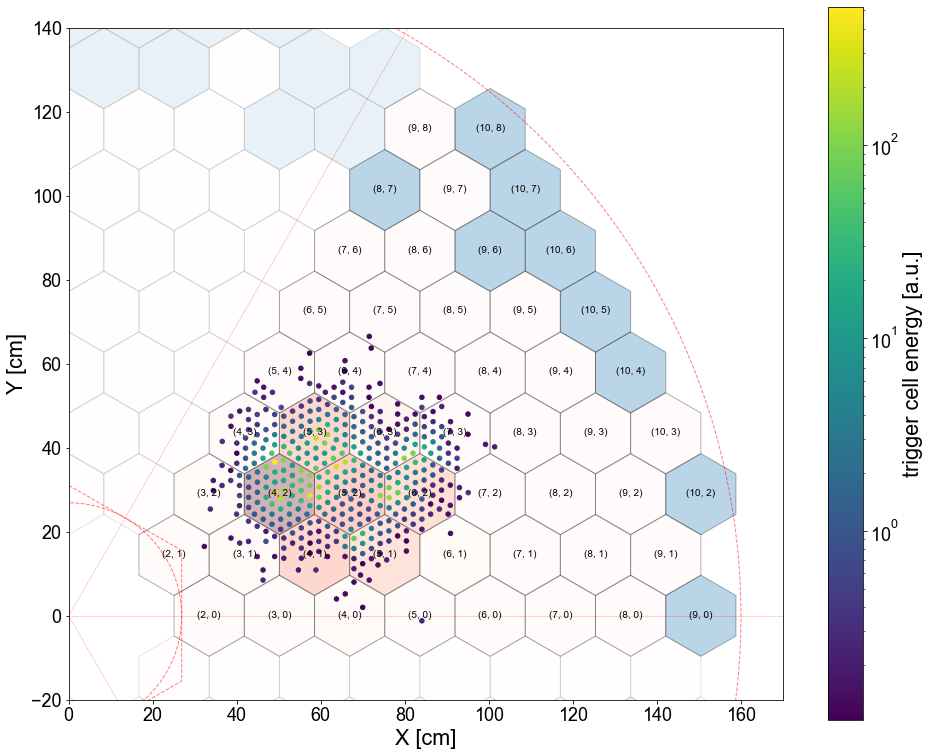

In [37]:
# Draw events within a single hex neighborhood

# make some plots
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

# get the events centered on neighborhood
uv = (5, 2)
events = gt.get_events_in_neighborhood(uv, df_cut)

wafer_data = df_cut.loc[events].groupby(['tc_waferu', 'tc_waferv']).sum()['tc_energy' ]
pt.draw_hgcal_layer(ax, wafer_data=wafer_data, single_wedge=True, include_index=True)

#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
random_e = np.random.choice(events, size=10, replace=False)
tc_sums = event_tc.loc[random_e].query(wedge_condition).groupby(['tc_x', 'tc_y']).sum()
tc_sums = tc_sums.query('tc_energy > 0.1')
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 20.
scat = ax.scatter(x, y,
                  marker='o', #(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )

cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
cbar.set_label('trigger cell energy [a.u.]')

plt.savefig('plots/first_wedge_neighborhood.png')
plt.show()

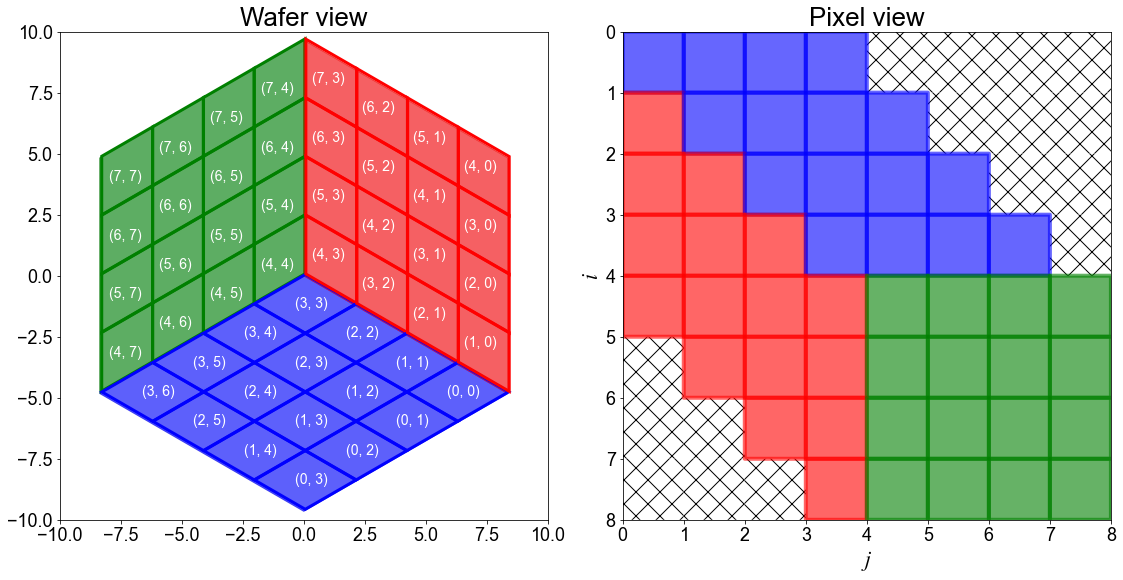

In [31]:
# Draw a single module
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

ax = axes[0]
ax.set_aspect('equal')

#ax.add_patch(poly)
pt.draw_single_module(ax, do_fill=True, include_tc_index=True)
ax.set_title('Wafer view')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
#ax.grid()
#ax.set_axisbelow(True)

ax = axes[1]
ax.set_aspect('equal')
pt.draw_single_module_pixels(ax)
ax.set_title('Pixel view')
#ax.grid()
#ax.axis('off')


plt.tight_layout()
plt.savefig('plots/tc_uv_mapping.pdf')
plt.show()

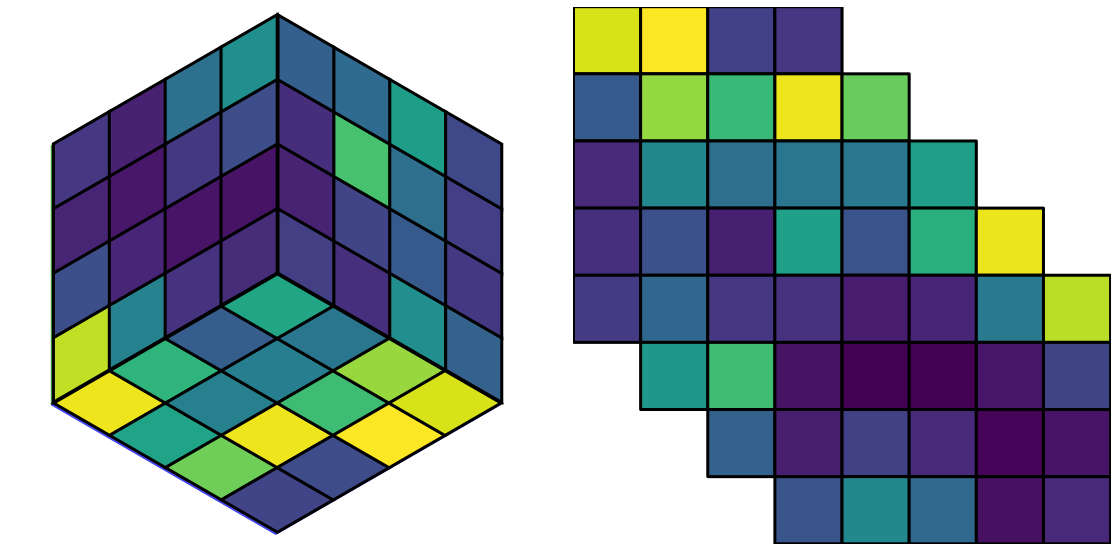

In [17]:
# Draw a single module
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

ax = axes[0]
ax.set_aspect('equal')

# overlay trigger cells.  Combine energy deposits from different events using groupby.
tc_uv = (4, 3)
wafer_tc = event_tc.query(f'tc_waferu == {tc_uv[0]} and tc_waferv == {tc_uv[1]}')
tc_data = wafer_tc.groupby(['tc_cellu', 'tc_cellv']).sum()['tc_energy']
tc_data /= tc_data.max()
pt.draw_single_module(ax, cell_data=tc_data, do_fill=True, include_tc_index=False)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.axis('off')

ax = axes[1]
ax.set_aspect('equal')
pt.draw_single_module_pixels(ax, cell_data=tc_data, no_axes=True)
ax.axis('off')

plt.tight_layout()
plt.savefig('plots/tc_uv_sample.pdf')
plt.show()

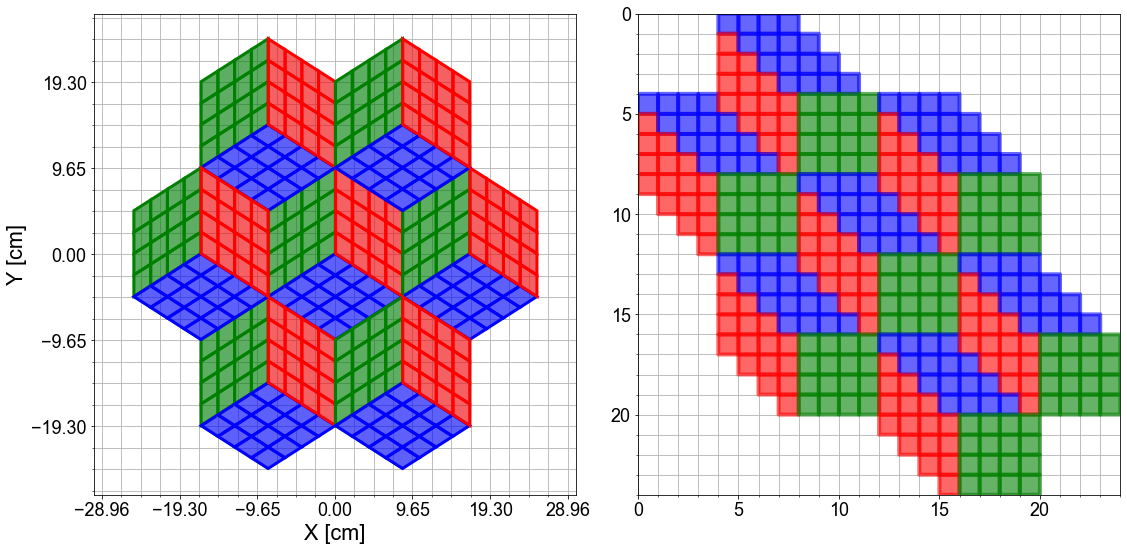

In [18]:
# Draw neighborhood of modules

# draw each module 
coord = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [-1, -1], [0, -1], [-1, 0]])

# make some plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

ax = axes[0]
# draw hexegonal grid
cmap = matplotlib.cm.get_cmap('Reds')
for u, v in coord:
    pt.draw_single_module(ax, uv_offset=(u, v), do_fill=True)
    
ax.set_xlim(-30, 30)
ax.set_ylim(-27, 27)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
#ax.axis('off')

from matplotlib.ticker import MultipleLocator
majorLocator = MultipleLocator(gt.hgcal_hex_radius)
# Set major tick locations.
ax.yaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_locator(majorLocator)
# Set grid to use minor tick locations. 
minorLocator = MultipleLocator(gt.hgcal_hex_radius/4)
# Set minor tick locations.
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)

# Set grid to use minor tick locations. 
ax.grid(which = 'both')
ax.set_axisbelow(True)

ax = axes[1]
color_coding = gt.wafer_mask_hgroc
img_grid = np.zeros((24, 24))
for uv, offset in gt.wafer_uv_offsets.items():
    img_grid[offset[0]:offset[0] + 8, offset[1]:offset[1] + 8] += color_coding
    
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ['g', 'b', 'r'])
img_grid[img_grid == 0] = np.nan                                      
ax.pcolor(img_grid, edgecolors='face', linewidths=4, cmap=cmap1, alpha=0.6)
ax.set_ylim(24, 0)

majorLocator = MultipleLocator(5)
# Set major tick locations.
ax.yaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_locator(majorLocator)
# Set grid to use minor tick locations. 
minorLocator = MultipleLocator(1)
# Set minor tick locations.
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)

# Set grid to use minor tick locations. 
ax.grid(which = 'both')
ax.set_axisbelow(True)

# plot the cluster graphs
plt.tight_layout()
plt.savefig('plots/neighborhood_mapping.pdf')
plt.show()

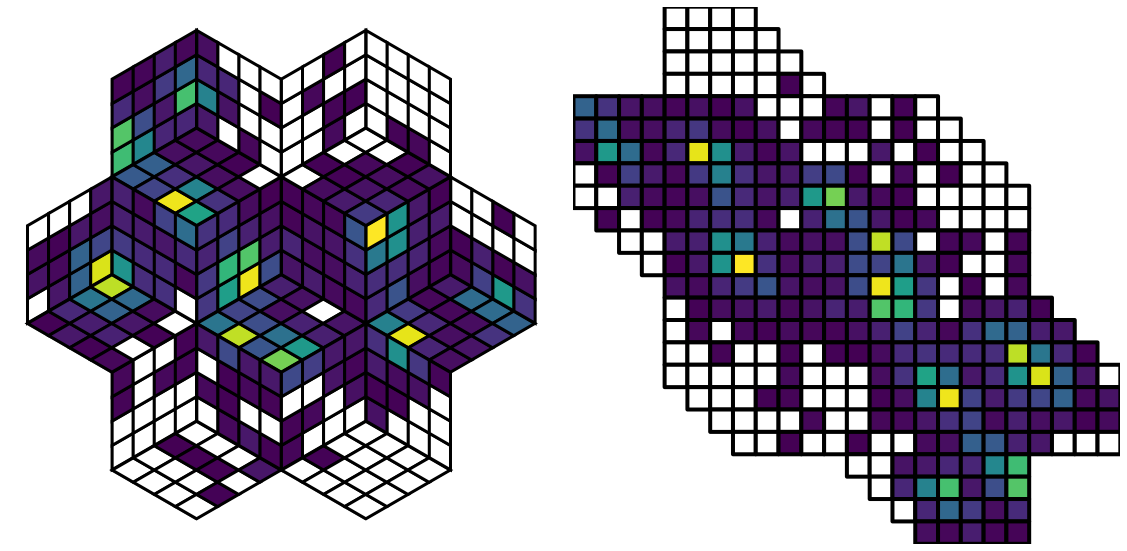

In [30]:
# Draw neighborhood of modules

# get the data and select a single layer
uv_center = (5, 2)
random_e = np.random.choice(events, size=10, replace=False)
#random_e = events[:5]
df_events = event_tc.loc[random_e].query('tc_layer == 9')

# make some plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

ax = axes[0]
ax.set_aspect('equal')

# draw hexegonal grid
wafer_group = ['tc_waferu', 'tc_waferv', 'tc_cellu', 'tc_cellv']
neighborhood_data = df_events.groupby(wafer_group).sum()['tc_energy']
for u, v in coord + uv_center:
    #wafer_data = neighborhood_data.loc[u, v]/neighborhood_data.max()
    wafer_data = np.log(1 + neighborhood_data.loc[u, v])/np.log(1 + neighborhood_data.max())
    if wafer_data.shape[0] != 0:
        #wafer_data = 1 - np.exp(wafer_data)
        pt.draw_single_module(ax, cell_data=wafer_data, uv_offset=(u, v), do_fill=False)
    
x_offset, y_offset = gt.hex_to_cartesian(uv_center)
ax.set_xlim(x_offset-27, x_offset+27)
ax.set_ylim(y_offset-25, y_offset+25)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.axis('off')

# Set grid to use minor tick locations. 
#ax.grid(which = 'both')
#ax.set_axisbelow(True)

ax = axes[1]
img_hits = gt.convert_wafer_neighborhood_to_array(neighborhood_data, hex_uv=uv_center, single_layer=True)
img_hits = np.log(1 + img_hits)/np.log(1 + img_hits.max())
img_hits[~gt.wafer_mask_14x24x24[0].astype(bool)] = np.nan
cmap = matplotlib.cm.get_cmap('viridis').copy()
cmap.set_under('white')
ax.pcolor(img_hits, edgecolors='k', linewidths=4, cmap=cmap, alpha=1., vmin=0.00001)#norm=colors.LogNorm(vmin=0.01))
ax.set_ylim(24, 0)
ax.set_xlim(0, 24)

majorLocator = MultipleLocator(5)
# Set major tick locations.
ax.yaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_locator(majorLocator)
# Set grid to use minor tick locations. 
minorLocator = MultipleLocator(1)
# Set minor tick locations.
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)

# Set grid to use minor tick locations. 
ax.grid(which = 'both')
ax.set_axisbelow(True)
ax.axis('off')

# plot the cluster graphs
plt.tight_layout()
plt.savefig('plots/neighborhood_event_example.pdf')
plt.show()

In [26]:
# Produce frames to animate shower by layers
fig, ax = plt.subplots(1, figsize=(12, 12))
for count in tqdm(range(10)):
    
    random_e = np.random.choice(events, size=10, replace=False)
    for ilayer in range(3, 29):
        ax.set_aspect('equal')

        # draw hexegonal grid
        wafer_group = ['tc_waferu', 'tc_waferv', 'tc_cellu', 'tc_cellv']
        if ilayer % 2 == 1:
            df_events = event_tc.loc[random_e].query(f'tc_layer == {ilayer}')
            neighborhood_data = df_events.groupby(wafer_group).sum()['tc_energy']
            
        else:
            continue
            #df_events = event_tc.loc[random_e].query(f'tc_layer == {ilayer - 1} or tc_layer == {ilayer + 1}')
            #neighborhood_data = df_events.groupby(wafer_group).sum()['tc_energy']
            
        for u, v in coord + uv_center:
            #wafer_data = neighborhood_data.loc[u, v]/neighborhood_data.max()
            if (u, v) in neighborhood_data.index:
                wafer_data = np.log(1 + neighborhood_data.loc[u, v])/np.log(1 + neighborhood_data.max())
                pt.draw_single_module(ax, cell_data=wafer_data, uv_offset=(u, v), do_fill=False)
            else:
                pt.draw_single_module(ax, uv_offset=(u, v), do_fill=False)

            ax.set_title(f'event {count}: layer {ilayer}')

        x_offset, y_offset = gt.hex_to_cartesian(uv_center)
        ax.set_xlim(x_offset-27, x_offset+27)
        ax.set_ylim(y_offset-25, y_offset+25)
        ax.set_xlabel('X [cm]')
        ax.set_ylabel('Y [cm]')
        ax.axis('off')

        # plot the cluster graphs
        fig.tight_layout()
        plt.savefig(f'plots/shower_animation/frame_{count}_{ilayer}.png')
        plt.cla()
        
plt.close(fig)

  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
# Illustrating hexagonal convolutions on a single module
from itertools import product
            
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

count = 0
for i, j in product(range(8), range(8)):
    if not gt.wafer_mask_8x8[i, j].astype(bool):
         continue
    
    ax = axes[0]
    ax.set_aspect('equal')

    hex_neighbors = gt.hex_neighbors((i, j))
    pt.draw_single_module(ax, do_fill=True, include_tc_index=False, convolution_mask=hex_neighbors)
    ax.set_title('Wafer view')
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])

    ax = axes[1]
    ax.set_aspect('equal')
    pt.draw_single_module_pixels(ax)
    
    wafer_grid = np.zeros((8, 8))
    idx, idy = np.array(hex_neighbors).T
    #idx, idx = idx[(idx >= 0) & (idy >= 0)], idy[(idx >= 0) & (idy >= 0)], 
    mask = (idx >= 0) & (idy >= 0) & (idx <= 7) & (idy <= 7)
    idx = idx[mask]
    idy = idy[mask]
    wafer_grid[idx, idy] = 1
    wafer_grid[wafer_grid == 0.] = np.nan
    ax.pcolor(wafer_grid, facecolor='none', edgecolor='k', linewidth=3., hatch='/')
    ax.set_title('Pixel view')

    plt.tight_layout()
    plt.savefig(f'plots/hex_convolution_animation/frame_{count}.png')
    plt.cla()
    count += 1
    
plt.close(fig)